#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn =   27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
# diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
diag_Irho = 1e-2*np.array([0.5, 0.5, 1])  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Irho=np.diag(diag_Irho)

In [11]:
Irho

array([[0.005, 0.   , 0.   ],
       [0.   , 0.005, 0.   ],
       [0.   , 0.   , 0.01 ]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
# Irho+=vessel_inertia

In [16]:
Irho

array([[0.005, 0.   , 0.   ],
       [0.   , 0.005, 0.   ],
       [0.   , 0.   , 0.01 ]])

In [17]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [18]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [19]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [20]:
E = 210e9

In [21]:
E*Ar/1e10

1.6991625880187402

In [22]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [23]:
DT=np.diag(diag_DT) # (35) in [2]

In [24]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [25]:
# diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
diag_CT = 1e10*np.array([1.7, 1.7, 1.7]) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [26]:
CT=np.diag(diag_CT)

In [27]:
CT

array([[1.7e+10, 0.0e+00, 0.0e+00],
       [0.0e+00, 1.7e+10, 0.0e+00],
       [0.0e+00, 0.0e+00, 1.7e+10]])

In [28]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [29]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [30]:
rng = np.random.default_rng()

In [31]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [32]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [33]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.51644944,  0.85431243, -0.05856832],
       [-0.46040318,  0.21935246, -0.86018219],
       [-0.72201724,  0.47120565,  0.50661262]])

In [34]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.011464


In [35]:
Ret.shape

(50, 3, 3)

In [36]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [37]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
#     print(Ret[0].shape, B.T[0].shape)
#     print(np.linalg.solve(Ret[0],B.T[0].astype(np.float64)).shape)
#     ans=[]
#     for i in range(len(B.T)):
#         ans.append(np.dot(Ret[i],np.linalg.solve(Ret[i],B.T[i].astype(np.float64))))
#         print(ans[-1])
#     ans=np.tensordot(Ret, np.linalg.solve(Ret,B.T.astype(np.float64)),axes = 0)
    return np.array(ans).T

In [38]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000957


In [39]:
C1(dx,dy,dz,Ret)

array([[ 6.11055070e-01,  1.13095227e+00, -2.34117147e-01,
        -1.45185427e+00, -3.09291257e-01,  1.19382961e-01,
        -5.92344380e+00, -1.04832328e+00, -1.75841693e-01,
         8.91502493e-02,  6.37158088e-02, -3.84165112e-01,
         6.00962674e-01,  1.51620585e+00,  2.62799972e-02,
        -8.36843721e-01, -2.04872962e+00, -2.18606511e+00,
         4.02938932e+00, -6.30134453e-01,  1.90711896e-01,
        -1.25606144e+00, -1.15091867e-02, -8.38214466e-01,
        -4.66778059e+00, -1.44802299e-01, -4.60625399e-01,
         1.34554130e+00,  4.69510945e-03, -1.26761432e+00,
         2.28435992e+00,  7.55347528e-01,  1.73762358e-01,
         5.90819953e-01, -1.60527741e+00,  2.52321170e-02,
         2.39332960e+00,  7.90488785e-02,  4.28163143e-01,
        -5.54905866e-01,  2.40751706e+00,  2.93189210e+00,
        -4.42827292e-02, -7.85738236e+00,  5.21666838e-01,
        -1.74580802e-01,  2.02572894e+00, -1.68625162e+00,
         9.43951878e-01,  4.11294433e-01],
       [-2.35

In [40]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [41]:
fD(dx,dy,dz,DT,Ret).T

array([[ 3.50686579e+03, -1.35380866e+03,  9.55715946e+02],
       [ 6.49057347e+03, -1.87545955e+04, -1.21746401e+04],
       [-1.34360625e+03, -2.72250014e+04, -8.98187619e+03],
       [-8.33224095e+03,  4.57639556e+02, -6.28059557e+03],
       [-1.77503302e+03, -2.17425394e+04,  2.50321010e+03],
       [ 6.85142866e+02,  2.13182691e+02, -8.19834287e+02],
       [-3.39948450e+04, -1.56684027e+02, -5.09204706e+02],
       [-6.01636288e+03,  8.43315575e+03,  7.25914432e+03],
       [-1.00916144e+03, -5.79398936e+02,  7.20444757e+03],
       [ 5.11636306e+02, -3.24614101e+04, -2.32449847e+04],
       [ 3.65667189e+02, -1.20653153e+03,  3.09705189e+03],
       [-2.20473662e+03,  2.51008885e+03,  2.59235318e+04],
       [ 3.44894518e+03, -4.53294576e+02,  4.90860196e+03],
       [ 8.70155682e+03, -1.03139588e+04, -2.84004206e+03],
       [ 1.50821796e+02, -5.79907866e+03,  6.07904879e+03],
       [-4.80267451e+03, -2.60722077e+03, -1.04182852e+04],
       [-1.17577288e+04,  2.35753808e+03

In [42]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.001502


In [43]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [44]:
I=np.identity(3)

In [45]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.001824


In [46]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [47]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [48]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [49]:
DR=np.diag(diag_DR) 

In [50]:
Ar

0.08091250419136858

In [51]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [52]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [53]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [54]:
def Re_b(Ret):
    return Ret

In [55]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000116


In [56]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))

In [57]:
phi(x,y,z,Ret,None,None)

array([[ 0.92251603,  1.52020248,  0.40642378],
       [ 2.57308074,  2.38897585,  0.42474558],
       [ 0.00706681,  0.43961717, -0.40048802],
       [-1.78319623, -0.05892098,  0.14415331],
       [ 0.40578958, -3.28772943,  0.25179483],
       [ 0.6780851 ,  0.56026706,  0.1470073 ],
       [-0.08949302,  0.99772139,  1.02850035],
       [ 1.99425137,  0.08435186,  1.85942935],
       [ 0.34523638,  0.26916899,  0.09817078],
       [ 1.37042635,  1.81343487,  2.83954451],
       [-1.85755811, -0.51045886, -0.37023131],
       [ 0.00677615, -0.14033425, -1.05825832],
       [ 1.13876496, -1.69101343,  1.83874277],
       [ 1.11227493, -0.02114268,  0.94008473],
       [-0.4467781 , -0.47847346,  0.74030439],
       [-0.9321839 , -1.92667608, -0.70938241],
       [-0.67681796, -1.13938027,  1.07708625],
       [ 0.0452943 , -0.49916403,  0.71775967],
       [-0.89123522,  1.93874698, -2.35678775],
       [ 0.12474643, -0.53105685, -1.43682597],
       [-0.47089047,  0.18614575,  0.917

In [58]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000232


In [59]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [60]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [61]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.002768


In [62]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [63]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.002527


In [64]:
ωe(φ,θ,ψ,None,None,None)

array([[-1.0971996 ,  1.67302908, -0.17999132],
       [ 1.09473309,  0.85362092, -0.45160136],
       [ 0.5084489 ,  0.43455664,  0.52699418],
       [ 0.06848271, -1.76489548, -0.78752688],
       [ 0.58585201,  0.56769471, -0.40384843],
       [ 0.35979978,  1.46647649,  1.18636601],
       [ 0.35954209, -1.53472353,  2.61400311],
       [ 0.38337653,  0.03406266, -0.10817376],
       [-0.50162013, -0.70959588, -0.45697063],
       [-0.83443289,  0.96364045,  0.70009536],
       [-0.92969982,  0.87123115,  0.10669174],
       [-0.918389  ,  0.92160024,  0.03414436],
       [-0.0686668 ,  1.66154228,  1.10172113],
       [-0.9488076 ,  0.03083358, -0.1231665 ],
       [ 1.35046926, -0.87172685, -0.27015124],
       [ 1.00279247, -0.09635953, -0.02648171],
       [-1.04669339, -0.05681073, -0.61361096],
       [-0.07037632,  0.72156627,  0.67348703],
       [-0.18270198,  0.55113435, -0.02310577],
       [ 0.45630348,  0.02997169, -0.22989892],
       [-1.68510094,  0.13536255, -0.429

In [65]:
def d_s(f,a,b,c,Ret,omega, force, flag=0): # here
    force=[0,0,0]
    
    fun = f(a,b,c,Ret,omega, force) 
    if flag==1:
        fun+=-np.dot(Ret,force)
#         fun*=-np.dot(Ret,force)
    elif flag==2:
        fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#         fun*=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)))
#     print(np.dot(np.linalg.inv(Π(φ,θ,ψ).astype(np.float64))[2],Re_b(Ret)[2]))
        
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun.astype(np.float64)).T

In [66]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [67]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None), [1,20,3],flag=2)

array([[-1.11376756e-05, -1.96421063e-05, -8.40096782e-06,
         2.03072261e-06,  3.53948887e-05, -4.13255637e-06,
         3.07786577e-07,  1.77505974e-05, -1.70996497e-06,
         1.02609938e-05,  1.40226151e-06, -9.17914892e-06,
         3.52972090e-05,  9.61217797e-06,  1.21876567e-05,
         1.21728150e-05,  2.21644436e-05,  1.21691153e-05,
        -4.29549178e-05, -9.05760056e-06,  7.31550573e-06,
        -9.62713941e-06, -1.22556771e-05,  2.19528806e-05,
         5.60286169e-07,  8.99736911e-06,  1.97034704e-05,
        -2.85353316e-05,  3.52882735e-05, -9.44108736e-07,
        -6.88062296e-06, -5.24285127e-06, -1.15550037e-05,
         2.27236834e-05,  2.61768050e-06, -4.44016637e-06,
        -1.58119305e-05, -8.83537233e-06,  3.43592872e-06,
         3.13580713e-06, -3.04660608e-05, -1.32988634e-05,
        -2.08151012e-05, -1.33154199e-05, -6.26855813e-06,
         2.15553753e-05,  1.29066057e-05,  1.88711457e-05,
        -1.35831772e-05,  2.17601846e-06],
       [ 5.16

In [68]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,0])
print(datetime.now() - startTime1)

0:00:00.004045


In [69]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega,force,flag=1).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [70]:
# np.dot(Ret.astype(np.float64)[2],np.array([1,0,0]).reshape(3,1)).squeeze()

In [71]:
# np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()

In [72]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [73]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,0])

array([[-2.01027016e-06,  4.25340853e-06, -2.93062799e-07,
        -1.34548748e-06,  4.67107647e-06, -4.88593951e-07,
         1.31692291e-06,  3.42190759e-06, -1.38345356e-07,
        -3.41741881e-06, -8.27764955e-07,  1.01542803e-07,
        -3.61068552e-06,  8.10139007e-07,  5.75700140e-07,
        -4.08563914e-08, -3.86105596e-07,  9.33498179e-07,
         1.91318342e-06, -1.79698284e-06, -1.22146080e-06,
         1.17128857e-06,  1.59684456e-06,  2.05139123e-06,
         2.86557087e-07,  1.77021223e-06,  2.90708732e-06,
         3.15602469e-06,  1.18490144e-07,  1.15851254e-06,
        -2.06696425e-07,  1.72348122e-07,  1.63019559e-06,
         1.22590195e-06, -2.26860795e-07, -1.34337891e-06,
         7.66018217e-07, -1.35038616e-06, -3.54469624e-07,
        -1.15418045e-07,  4.77325866e-07, -2.19554060e-06,
        -1.36144634e-06, -2.52320712e-07,  7.43485337e-08,
        -3.56007506e-06, -9.41815962e-07, -3.56979525e-06,
        -1.42948792e-06, -2.31310779e-07],
       [ 2.21

In [74]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [75]:
ne_(dx,dy,dz,DT,Ret)

array([[-3.50686579e+03, -6.49057347e+03,  1.34360625e+03,
         8.33224095e+03,  1.77503302e+03, -6.85142866e+02,
         3.39948450e+04,  6.01636288e+03,  1.00916144e+03,
        -5.11636306e+02, -3.65667189e+02,  2.20473662e+03,
        -3.44894518e+03, -8.70155682e+03, -1.50821796e+02,
         4.80267451e+03,  1.17577288e+04,  1.25459019e+04,
        -2.31248020e+04,  3.61636301e+03, -1.09450204e+03,
         7.20857921e+03,  6.60516130e+01,  4.81054127e+03,
         2.67885512e+04,  8.31025309e+02,  2.64354480e+03,
        -7.72210721e+03, -2.69453925e+01,  7.27488160e+03,
        -1.31100191e+04, -4.33496510e+03, -9.97228070e+02,
        -3.39073576e+03,  9.21274155e+03, -1.44807976e+02,
        -1.37353998e+04, -4.53664196e+02, -2.45724281e+03,
         3.18462360e+03, -1.38168221e+04, -1.68262283e+04,
         2.54140086e+02,  4.50937840e+04, -2.99386369e+03,
         1.00192515e+03, -1.16257271e+04,  9.67745526e+03,
        -5.41737186e+03, -2.36043271e+03],
       [ 1.35

In [76]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.006451


In [77]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None), [0,0,1]).T

array([[-2.88077530e+03,  1.75673073e+00,  2.87902433e+03],
       [ 2.77367684e+03, -5.49198998e+03,  2.71830759e+03],
       [ 9.72280930e+03, -9.31365964e+03, -4.09169103e+02],
       [ 5.35844006e+02,  1.75826280e+03, -2.29410788e+03],
       [ 3.36465593e+03, -1.41207995e+04,  1.07561368e+04],
       [ 1.21525417e+02, -4.03497189e+02,  2.81971529e+02],
       [ 1.50758753e+03,  1.67430273e+04, -1.82506178e+04],
       [-1.11954498e+03, -1.71488452e+04,  1.82683924e+04],
       [-4.54850078e+03, -3.30083712e+03,  7.84934700e+03],
       [ 4.31783619e+03, -5.56468008e+03,  1.24683526e+03],
       [-3.12733260e+03, -2.82481016e+03,  5.95214901e+03],
       [-3.41107900e+03, -2.47613006e+03,  5.88721589e+03],
       [ 6.07891092e+02, -1.23126293e+02, -4.84766014e+02],
       [-2.65190304e+03, -9.47581834e+03,  1.21277267e+04],
       [-5.33077901e+02, -3.27204165e+03,  3.80512062e+03],
       [ 7.88341411e+02, -1.34267406e+04,  1.26383976e+04],
       [ 3.00565628e+02, -1.50549891e+04

In [78]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[ 1.61344736e+07,  2.89515589e+09,  1.43777124e+07],
       [-2.34171477e+09,  3.76594785e+08,  3.15027440e+09],
       [-5.67548680e+09, -6.08464414e+09,  3.63817488e+09],
       [ 9.75317875e+07, -2.19657399e+09, -1.66072945e+09],
       [-1.01233136e+10,  6.32832752e+08,  3.99749204e+09],
       [-2.23357945e+07,  2.59635497e+08,  3.81161036e+08],
       [ 1.64790956e+10, -1.77153695e+09, -2.63947909e+08],
       [-1.66508750e+10,  1.61753242e+09,  4.97986317e+08],
       [-7.40059505e+09,  4.48758905e+08, -4.09974643e+09],
       [-2.16706467e+09, -9.20226326e+08,  3.39761418e+09],
       [-2.09222958e+09,  3.85991767e+09,  7.32581945e+08],
       [-1.62833355e+09,  4.25887971e+09,  8.47797296e+08],
       [ 1.31232663e+07, -4.71642289e+08,  1.36249410e+08],
       [-9.73952640e+09,  2.38820764e+09, -2.63698053e+08],
       [-3.81661494e+09, -1.14904909e+07, -5.44568925e+08],
       [-1.39837478e+10, -1.34533488e+09, -5.56992680e+08],
       [-1.50990859e+10, -3.44647577e+08

In [79]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.001429


In [80]:
Re_b(Ret).shape

(50, 3, 3)

In [81]:
# def Irho_e(Ret):
    
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    
#     sum_=np.zeros(Irho.shape)
# #     print(sum_)
    
#     for i in range(len(ans1)):
#         sum_+=ans1[i]
#         ans1[i]=sum_
        
#     tmp=np.zeros(Irho.shape)
#     np.fill_diagonal(tmp, vessel_inertia)
    
#     ans2=np.multiply(np.multiply(Ret,tmp),Ret)
#     ans1[-1]+=ans2[-1]
    
#     for i in range(int(node_N/4)):
#         ans1[i]*=(10-i+1)
#     return ans1
def Irho_e(Ret): # here
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans

In [82]:
Irho_e(Ret)

array([[[4.82885175e-05, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.57225500e-04, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.89582906e-05]],

       [[1.33360010e-03, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.40577518e-04, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.56656347e-03]],

       [[2.40624098e-03, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.73621695e-03, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 7.09513621e-03]],

       [[1.60238862e-04, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.35622557e-03, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.03390366e-03]],

       [[3.53905301e-03, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.86146453e-03, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 4.38204456e-03]],

       [[5.99796464e-05, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 3.95861703e-04, 0.00000000e+00],
    

In [83]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000174


In [84]:
79.3*1e9*math.pi*(d0**4-dI**4)/64

423167467.8322429

In [85]:
# diag_CR = 1e11*np.array([1, 1, 1])
diag_CR = 1e9*np.array([4, 4, 4]) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

CR=np.diag(diag_CR)

In [86]:
CR

array([[4.e+09, 0.e+00, 0.e+00],
       [0.e+00, 4.e+09, 0.e+00],
       [0.e+00, 0.e+00, 4.e+09]])

In [87]:
def d_me(φ,θ,ψ,Ret,fun,omega,force):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,Ret,omega,force,flag=2)
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float64)) 

In [88]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None,None),[1,2,3])
print(datetime.now() - startTime1)

0:00:00.008783


In [89]:
d_me_

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0

In [90]:
# diag_DR = 1.5*np.array([1, 1, 1]) 
 
# DR=np.diag(diag_DR)

In [91]:
ne_(dx,dy,dz,DT,Ret)

array([[-3.50686579e+03, -6.49057347e+03,  1.34360625e+03,
         8.33224095e+03,  1.77503302e+03, -6.85142866e+02,
         3.39948450e+04,  6.01636288e+03,  1.00916144e+03,
        -5.11636306e+02, -3.65667189e+02,  2.20473662e+03,
        -3.44894518e+03, -8.70155682e+03, -1.50821796e+02,
         4.80267451e+03,  1.17577288e+04,  1.25459019e+04,
        -2.31248020e+04,  3.61636301e+03, -1.09450204e+03,
         7.20857921e+03,  6.60516130e+01,  4.81054127e+03,
         2.67885512e+04,  8.31025309e+02,  2.64354480e+03,
        -7.72210721e+03, -2.69453925e+01,  7.27488160e+03,
        -1.31100191e+04, -4.33496510e+03, -9.97228070e+02,
        -3.39073576e+03,  9.21274155e+03, -1.44807976e+02,
        -1.37353998e+04, -4.53664196e+02, -2.45724281e+03,
         3.18462360e+03, -1.38168221e+04, -1.68262283e+04,
         2.54140086e+02,  4.50937840e+04, -2.99386369e+03,
         1.00192515e+03, -1.16257271e+04,  9.67745526e+03,
        -5.41737186e+03, -2.36043271e+03],
       [ 1.35

### Static solution

In [92]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [93]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [94]:
Fx_0=82945396

In [95]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [96]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [97]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [98]:
delta_x=horizontal_length/(node_N-1)

In [99]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [100]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [101]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

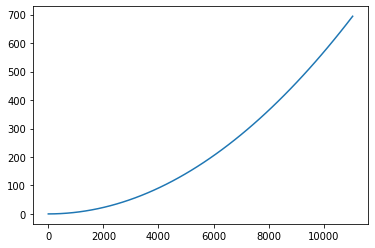

In [102]:
plt.plot(x0, z0)
plt.show()

In [103]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [104]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [105]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
#     Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None), tau_force[:3],flag=1).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 #+ Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################    

#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None,None),tau_force[3:])
    B_ =C3
    B=(B_ #+ C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [106]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [107]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [108]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [109]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [110]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [111]:
x0_

array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
         902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
        1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
        2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
        3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
        4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
        5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
        6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
        7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
        8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
        9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
        9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
       10827.11984764, 11052.68484446])

In [112]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [113]:
z0_

array([0.00000000e+00, 2.88842843e-01, 1.15537327e+00, 2.59959695e+00,
       4.62152338e+00, 7.22116580e+00, 1.03985413e+01, 1.41536706e+01,
       1.84865785e+01, 2.33972933e+01, 2.88858473e+01, 3.49522764e+01,
       4.15966205e+01, 4.88189230e+01, 5.66192315e+01, 6.49975970e+01,
       7.39540746e+01, 8.34887228e+01, 9.36016044e+01, 1.04292786e+02,
       1.15562337e+02, 1.27410331e+02, 1.39836847e+02, 1.52841966e+02,
       1.66425773e+02, 1.80588357e+02, 1.95329812e+02, 2.10650233e+02,
       2.26549722e+02, 2.43028382e+02, 2.60086322e+02, 2.77723654e+02,
       2.95940493e+02, 3.14736958e+02, 3.34113174e+02, 3.54069267e+02,
       3.74605368e+02, 3.95721612e+02, 4.17418136e+02, 4.39695085e+02,
       4.62552603e+02, 4.85990841e+02, 5.10009952e+02, 5.34610093e+02,
       5.59791427e+02, 5.85554119e+02, 6.11898337e+02, 6.38824254e+02,
       6.66332046e+02, 6.94421895e+02])

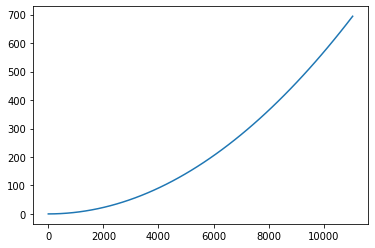

In [114]:
plt.plot(x0_, z0_)
plt.show()

In [115]:
init=1e-3
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=np.array([-0.0001*i*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([0.0002*i*init for i in range(node_N)])
        q0[(j-1)*node_N]=0 
# q0[9*node_N-1]=0.13  # here

In [116]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

### Vessle Simulation

In [117]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [159]:
vehicle=semisub('DPcontrol',-5,0,40.0,0,0) 

In [160]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [161]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

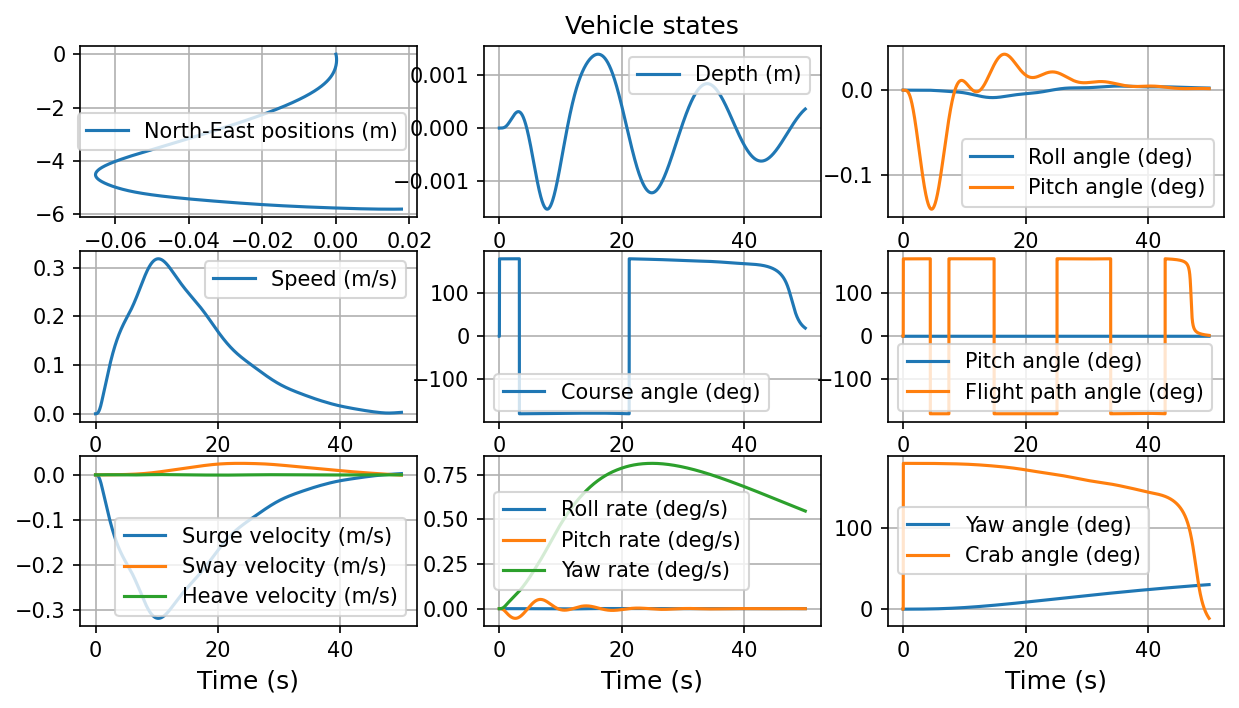

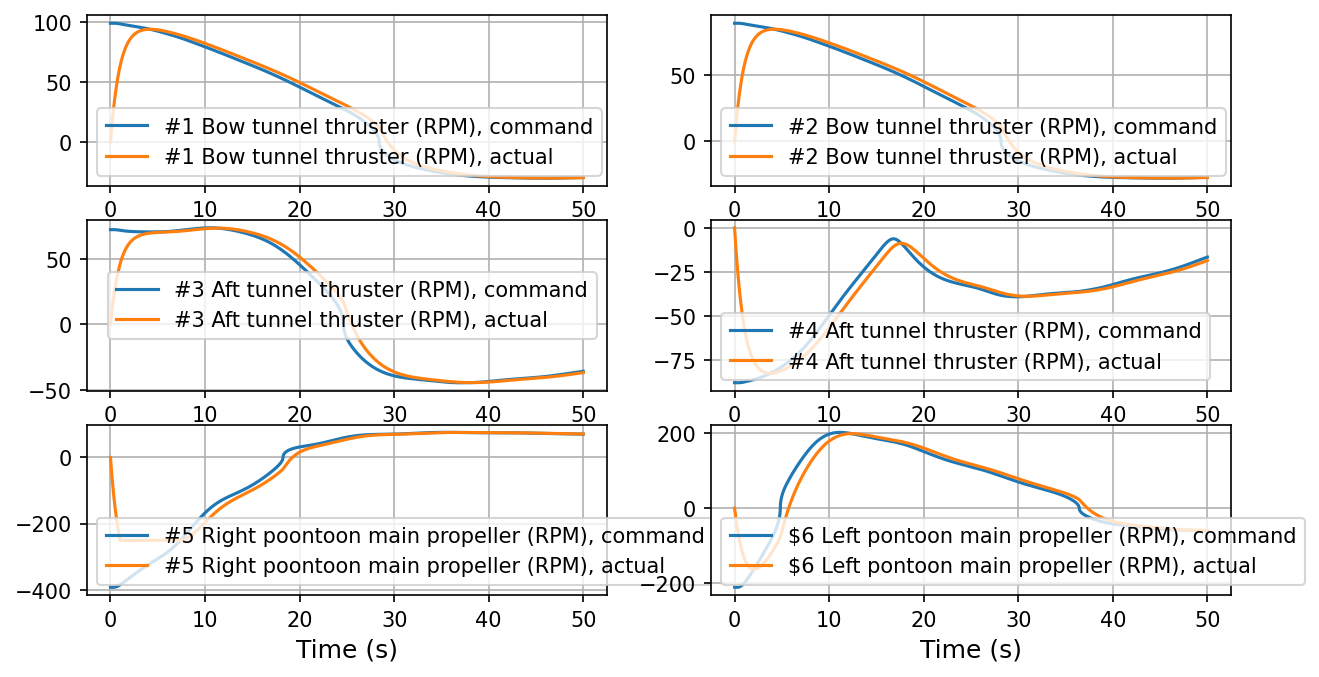

In [162]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [163]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

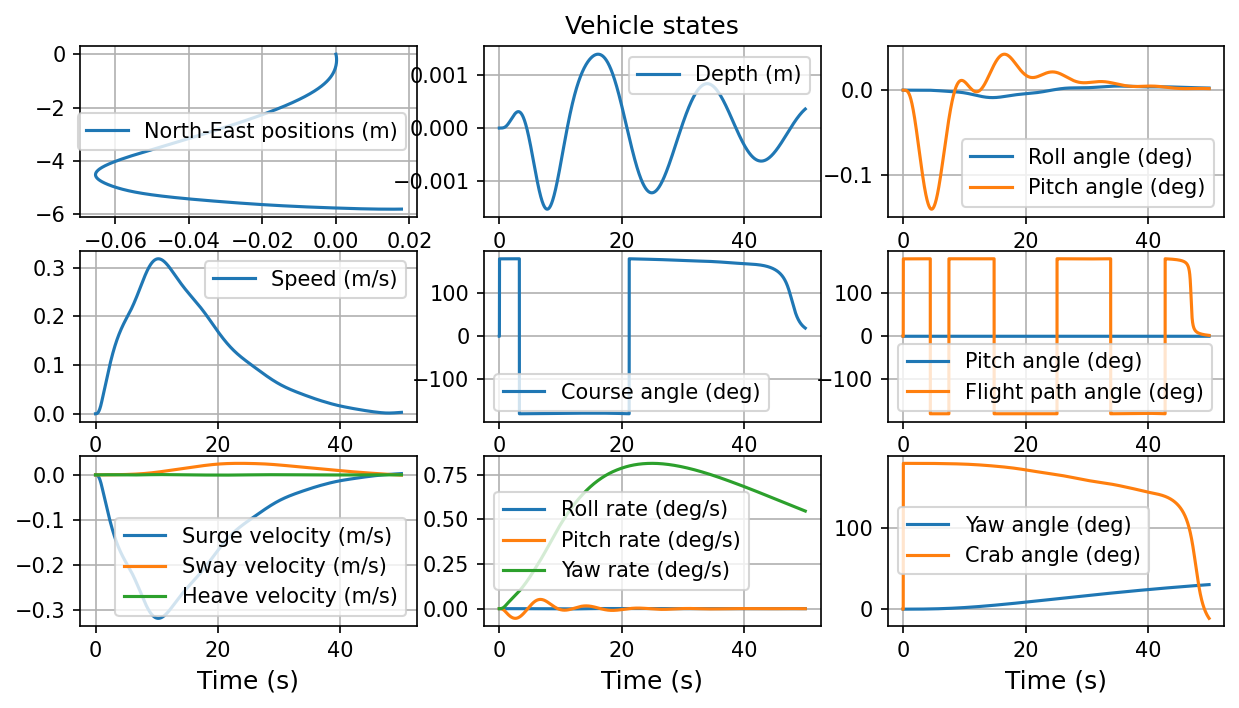

In [164]:
plotVehicleStates(simTime, simData, 3)

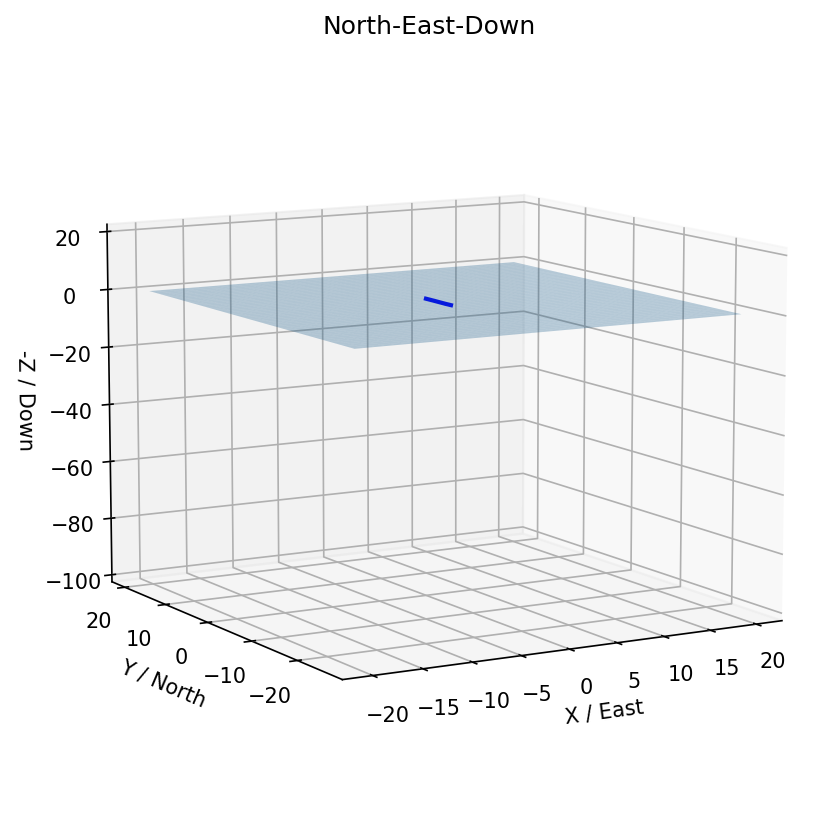

In [165]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [166]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [167]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [168]:
# Ws[0]*Ret[2]

In [169]:
# np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N)],Ret)

### Dynamics

In [170]:
def grayscott1d(t, Q): # here
#     print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
#     x_ve = simData[:, 1][idx]
#     y_ve = simData[:, 0][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
#     u_ve = simData[:, 7][idx]
#     v_ve = simData[:, 6][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
#     force_schedule=100
    force_schedule=1
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]
#     print(tau_force)
#     tau_force[0]=0
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0

#     print(Ret)
    Z0=-np.dot(Re_b(Ret),tau_force[:3])
#     print(Z0)
#     print(Z0)
    Z1 =d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None), tau_force[:3], flag=1).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T
#     print(Z0)

    Z= (Z1 + Z2 +Z0
       )
#     print(Z0,Z1,Z2)
#     Z[-1]+=tau_force[:3]

############################################################    

    RRRR=Re_b(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N)]
#                                              +[Ws[-1] + vessel_mass]
                                          
                                             ,RRRR),
                                   Z
                                  ).T 
#     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      

    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None,None),tau_force[3:])
    
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),[None,None,None]).T, 
                 ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),tau_force[:3]))
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
#     print(B)   

    A2 = Irho_e(Ret).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
    

#     hack=1e18
    hack=1e22
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111)
    return A1111

In [171]:
# import scipy

In [172]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=32, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [173]:
# us=ode15s.integrate(10)

In [174]:
tspan = (0., 1)

In [175]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0:01:51.844375


In [176]:
# key takeaway: you can calibrate the model by tuning the hack and bc(init) 
# force_schedule also affect solution

### Results

In [177]:
fin=us

In [178]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 4304
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 9.33860735e-09, 5.13656670e-08, 2.25790937e-07,
       8.79702320e-07, 3.19945178e-06, 1.12932194e-05, 3.94193408e-05,
       1.37074972e-04, 4.76114907e-04, 1.26283513e-03, 2.04955535e-03,
       2.85232385e-03, 3.86695205e-03, 5.18597065e-03, 6.97932351e-03,
       8.93311533e-03, 1.08869072e-02, 1.24685074e-02, 1.40501077e-02,
       1.59115835e-02, 1.76419440e-02, 1.93723045e-02, 2.12153554e-02,
       2.29965709e-02, 2.46148987e-02, 2.61698083e-02, 2.78384883e-02,
       2.96726709e-02, 3.15134148e-02, 3.31825063e-02, 3.47180197e-02,
       3.63161511e-02, 3.81093543e-02, 3.99959870e-02, 4.15416325e-02,
       4.30872780e-02, 4.49195812e-02, 4.66831217e-02, 4.84466623e-02,
       5.02804126e-02, 5.20138778e-02, 5.36009425e-02, 5.51732828e-02,
       5.68852218e-02, 5.87313792e-02, 

In [179]:
t=fin.t

In [180]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


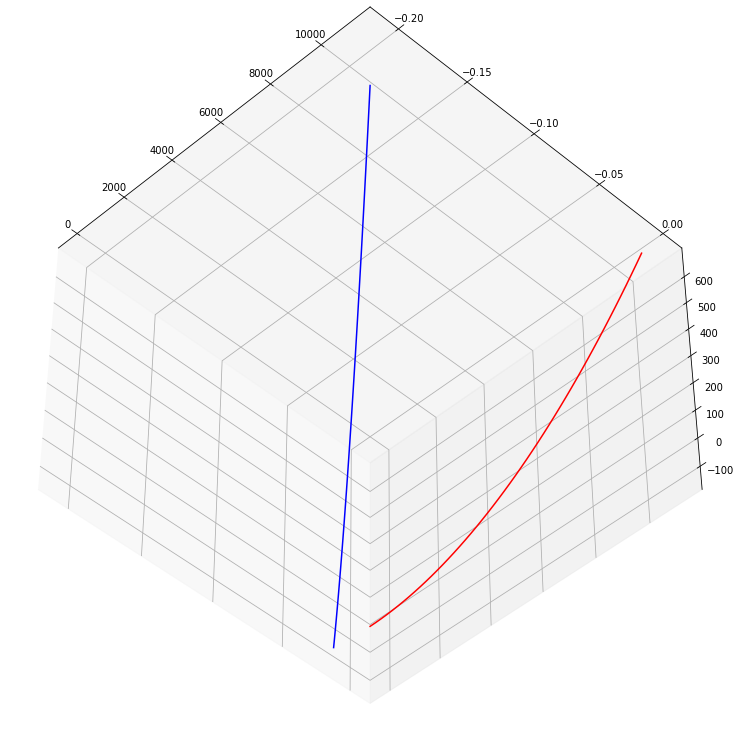

In [181]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
# ax.view_init(0,-90)
plt.show()

In [182]:
X,Y,Z

(array([   35.06691493,   260.63191136,   486.19690546,   711.76189492,
          937.32687747,  1162.89185082,  1388.45681268,  1614.02176077,
         1839.58669278,  2065.15160645,  2290.71649947,  2516.28136957,
         2741.84621445,  2967.41103182,  3192.9758194 ,  3418.5405749 ,
         3644.10529604,  3869.66998051,  4095.23462604,  4320.79923033,
         4546.3637911 ,  4771.92830605,  4997.4927729 ,  5223.05718936,
         5448.62155313,  5674.18586193,  5899.75011346,  6125.31430543,
         6350.87843555,  6576.44250152,  6802.00650106,  7027.57043187,
         7253.13429165,  7478.69807811,  7704.26178895,  7929.82542187,
         8155.38897459,  8380.95244479,  8606.51583018,  8832.07912845,
         9057.64233731,  9283.20545446,  9508.76847758,  9734.33140437,
         9959.89423253, 10185.45695974, 10411.0195837 , 10636.5821021 ,
        10862.14451262, 11087.70681294]),
 array([-0.02772212, -0.03134642, -0.03497072, -0.03859502, -0.04221931,
        -0.04584361, 

In [183]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [184]:
us=fin.T

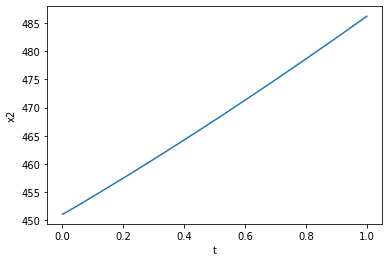

In [185]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

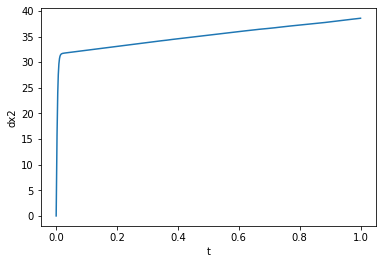

In [186]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

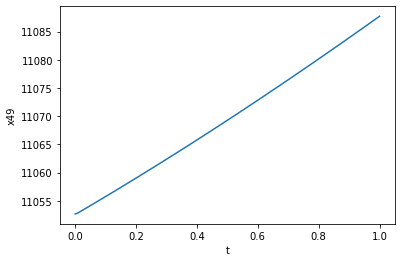

In [187]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

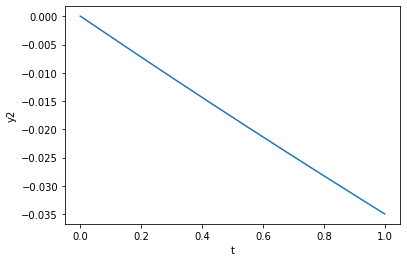

In [188]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

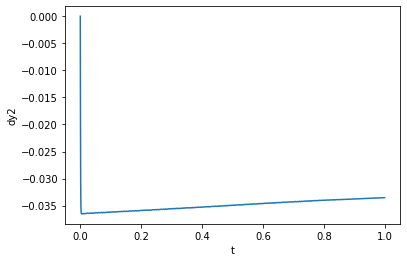

In [189]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

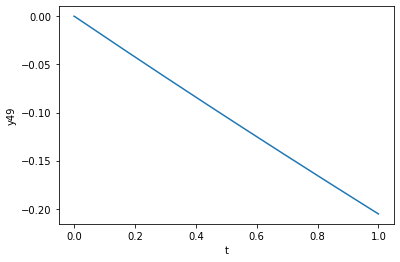

In [190]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

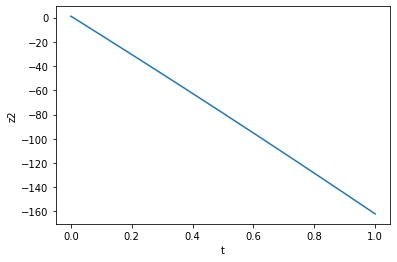

In [191]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

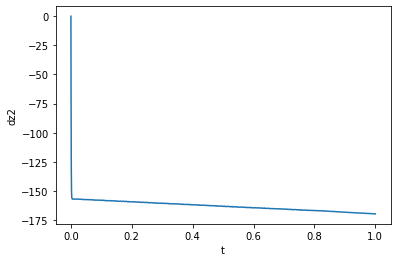

In [192]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

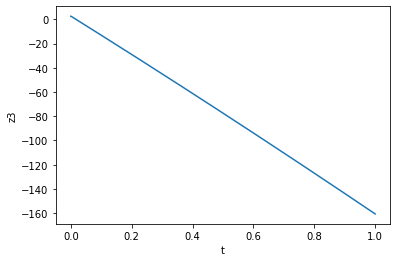

In [193]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

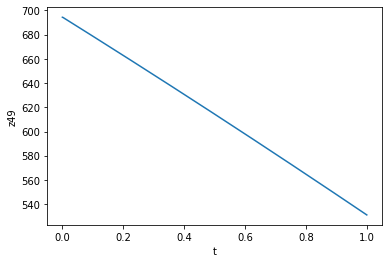

In [194]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

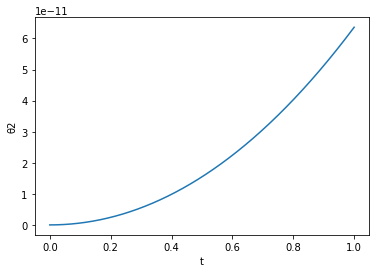

In [195]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

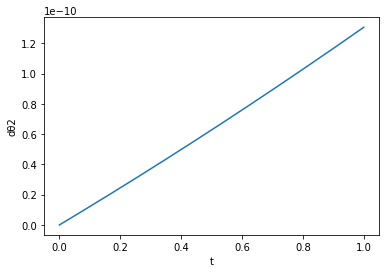

In [196]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

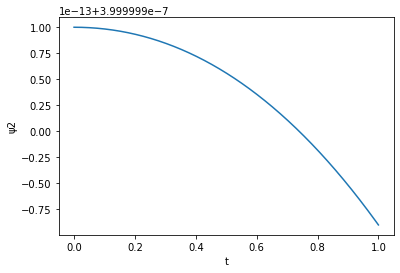

In [197]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

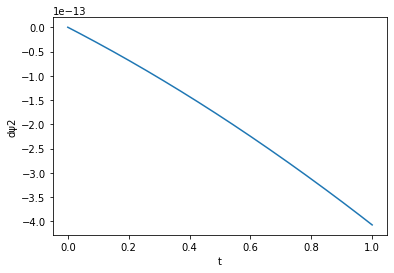

In [198]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()